In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from sklearn.decomposition import PCA, FastICA
from scipy.stats import zscore

### EEG

Import EEG data using [MNE Python](https://mne.tools/stable/index.html) analysis package. We will be using open-source data which has been reported in:

[Babayan, A., Erbey, M., Kumral, D. et al. *A mind-brain-body dataset of MRI, EEG, cognition, emotion, and peripheral physiology in young and old adults.* Sci Data 6, 180308 (2019).](https://www.nature.com/articles/sdata2018308)

In [ ]:
eeg = mne.io.read_raw_eeglab("sub-010321_EC_downsamp.set")

eeg.annotations.delete( np.arange( len(eeg.annotations.description) ) )  # remove annotations, not important

In [ ]:
%matplotlib notebook
eeg.plot(n_channels=10);
eeg.plot_sensors(show_names=True, sphere=90);

In [ ]:
num_comps = 15  # choose number of patterns, or "components"

eeg_ts = eeg.get_data().T
pca = PCA(n_components=num_comps)
pca_data_ts = pca.fit_transform(eeg_ts)

In [ ]:
len_plot = 1000     # choose time-series length for plotting purposes

num_plots = pca_data_ts.shape[1]
plt.figure(figsize=[9.,9.])

for i in range(num_plots):
    ax = plt.subplot( num_plots , 1, i+1 )
    plt.plot(zscore(pca_data_ts)[:len_plot,i])
    
    ax.set_ylabel("PCA {}".format(i), fontsize=8, rotation=0)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    
plt.tight_layout()
plt.show()

In [ ]:
dir(ica)

In [ ]:
num_comps = 15  # choose number of patterns, or "components"

ica = ICA(n_components=num_comps, random_state=97)
ica.fit(eeg)

 ### !!! Check if can highjack ica.plot_components method for PCA !!!

In [ ]:
%matplotlib inline
ica.plot_sources(eeg);
ica.plot_components();

### scRNA-seq

In [15]:
import pickle
import scanpy as sc
import random
import pandas as pd
import anndata
import matplotlib.pyplot as plt

In [12]:
## Import and format data

random.seed(10)

# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)

df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('sample_info.csv')

mp_anndata = anndata.AnnData(X=X)
mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values
celltype_one_hot = pd.get_dummies(mp_anndata.obs['Celltype'], prefix='Celltype').values

N = X.shape[0]  # number of single-cell samples
K = len(sample_info['assigned_cluster'].unique())  # number of topics
M = X.shape[1]  # number of genes

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


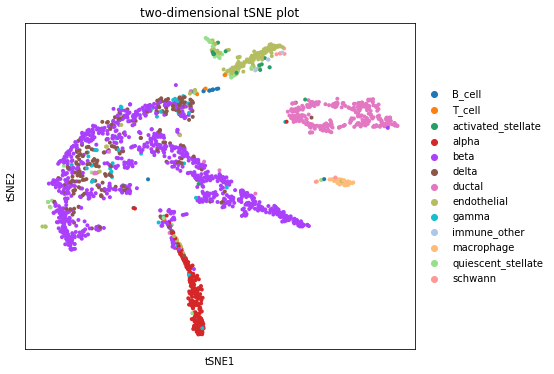

In [29]:
## Compute neighbor affinities and run tSNE

_, ax = plt.subplots(figsize=(7, 6))

sc.pp.neighbors(mp_anndata, n_neighbors=30)
sc.tl.tsne(mp_anndata, n_pcs=10)
sc.pl.tsne(mp_anndata, color=["Celltype"], ax=ax, title='two-dimensional tSNE plot')

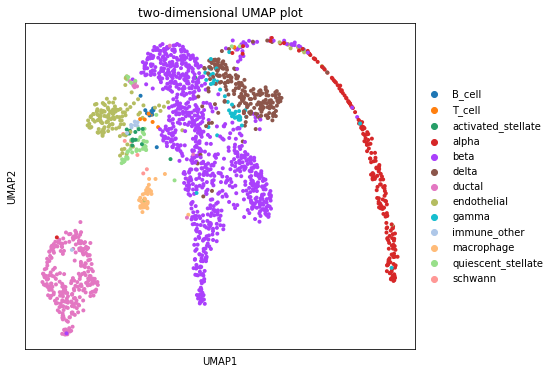

In [31]:
_, ax = plt.subplots(figsize=(7, 6))

sc.tl.umap(mp_anndata)
sc.pl.umap(mp_anndata, color=["Celltype"], ax=ax, title='two-dimensional UMAP plot')

### Autoencoders
Adapted from: https://www.theaidream.com/post/an-introduction-to-autoencoder-and-variational-autoencoder-vae

In [ ]:
import numpy as np
import keras
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt

Vanilla AE

In [ ]:
# This is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
hidden_dim = 64

# This is our input image
input_img = keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
hidden_enc = layers.Dense(hidden_dim, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(hidden_enc)
ae_encoder = keras.Model(input_img, encoded, name='encoder')

# "decoded" is the lossy reconstruction of the input
encoded_inputs = keras.Input(shape=(encoding_dim,), name='z_sampling')
hidden_dec = layers.Dense(hidden_dim, activation='relu')(encoded_inputs)
decoded = layers.Dense(784, activation='sigmoid')(hidden_dec)
ae_decoder = keras.Model(encoded_inputs, decoded, name='decoder')

output_img = ae_decoder(ae_encoder(input_img))

autoencoder = keras.Model(input_img, output_img, name='ae')

#Now let's train our autoencoder to reconstruct MNIST digits.
#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

(x_train, _), (x_test, _) = mnist.load_data()

#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#Now let's train our autoencoder for 50 epochs:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

#After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

# Encode and decode some digits
# Note that we take them from the *test* set

encoded_imgs = ae_encoder.predict(x_test)
decoded_imgs = ae_decoder.predict(encoded_imgs)
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
batch_size = 32

x_test_encoded = ae_encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.flip(np.linspace(0, 120, n))
grid_y = np.linspace(0, 100, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = ae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Variational AE

In [ ]:
#First, here's our encoder network, mapping inputs to our latent distribution parameters:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

#We can use these parameters to sample new similar points from the latent space:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

#Finally, we can map these sampled latent points back to reconstructed inputs:
# Create encoder
vae_encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)

vae_decoder = keras.Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = vae_decoder(vae_encoder(inputs)[2])

vae = keras.Model(inputs, outputs, name='vae_mlp')

#We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


#We train our VAE on MNIST digits:
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

In [ ]:
batch_size = 32

x_test_encoded = vae_encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:,0], x_test_encoded[0][:,1], c=y_test, cmap='tab10')
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-15, 15]
grid_x = np.flip(np.linspace(-3, 3, n))
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()